In [656]:
import pandas as pd
import altair as alt
import numpy as np
import re
import itertools
import random
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

alt.data_transformers.enable('json')
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [669]:
train = pd.read_csv('./data/TrainingSet.csv', index_col=0)

In [670]:
train.head(10)

,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],1981 [YR1981],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,22.423064,Afghanistan,allsa.gen_pop,(%) Generosity of All Social Safety Nets
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.520560,Afghanistan,allsi.cov_pop,(%) Program participation - All Social Insurance
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.963125,Afghanistan,allsp.cov_pop,(%) Program participation - All Social Protection
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.513759,Afghanistan,allsa.cov_pop,(%) Program participation - All Social Safety ...
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,Afghanistan,lm_ub.cov_pop,(%) Program participation - Unemp benefits and...


In [671]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195402 entries, 0 to 286117
Data columns (total 39 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   1972 [YR1972]  64945 non-null   float64
 1   1973 [YR1973]  64443 non-null   float64
 2   1974 [YR1974]  64966 non-null   float64
 3   1975 [YR1975]  66973 non-null   float64
 4   1976 [YR1976]  67717 non-null   float64
 5   1977 [YR1977]  69735 non-null   float64
 6   1978 [YR1978]  69763 non-null   float64
 7   1979 [YR1979]  69906 non-null   float64
 8   1980 [YR1980]  75250 non-null   float64
 9   1981 [YR1981]  78034 non-null   float64
 10  1982 [YR1982]  79016 non-null   float64
 11  1983 [YR1983]  78982 non-null   float64
 12  1984 [YR1984]  79532 non-null   float64
 13  1985 [YR1985]  81017 non-null   float64
 14  1986 [YR1986]  81455 non-null   float64
 15  1987 [YR1987]  82752 non-null   float64
 16  1988 [YR1988]  83242 non-null   float64
 17  1989 [YR1989]  86331 non-null

There seems to be quite a lot of missing data, especially in the early years. Even in the latest years, the data are not intact. There is no guarantee that it won't affect the series we care about and want to predict for.

In [672]:
all_series = train['Series Name'].unique()

In [673]:
len(all_series)

1305

The amount of series way exceeds my expectation. That means it won't easy to find correlation and visualize the data.

In [674]:
all_series[:50]

array(['(%) Benefits held by 1st 20% population - All Social Insurance',
       '(%) Benefits held by 1st 20% population - All Social Protection',
       '(%) Benefits held by 1st 20% population - All Social Safety Nets',
       '(%) Generosity of All Social Insurance',
       '(%) Generosity of All Social Protection',
       '(%) Generosity of All Social Safety Nets',
       '(%) Program participation - All Social Insurance',
       '(%) Program participation - All Social Protection',
       '(%) Program participation - All Social Safety Nets',
       '(%) Program participation - Unemp benefits and ALMP',
       '2005 PPP conversion factor, GDP (LCU per international $)',
       '2005 PPP conversion factor, private consumption (LCU per international $)',
       'Achieve universal primary education',
       'Adjusted net enrollment rate, primary, female (% of primary school age children)',
       'Adjusted net enrollment rate, primary, male (% of primary school age children)',
       '

Looks like there is a huge variety of series measuring different things. Let's check out the ones related to our predictions.

In [675]:
submission_rows = pd.read_csv('./data/SubmissionRows.csv', index_col=0)

In [676]:
submission_rows.head(10)

,2008 [YR2008],2012 [YR2012]
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN
1955,NaN,NaN
2090,NaN,NaN
2690,NaN,NaN
3233,NaN,NaN
3292,NaN,NaN


In [677]:
submission_rows.index

Int64Index([   559,    618,    753,   1030,   1896,   1955,   2090,   2690,
              3233,   3292,
            ...
            283137, 283460, 284003, 284062, 284197, 284474, 285340, 285399,
            285534, 285811],
           dtype='int64', length=737)

In [678]:
submission_series = train.loc[submission_rows.index]['Series Name'].unique()
submission_series

array(['Ensure environmental sustainability',
       'Develop a global partnership for development: Internet Use',
       'Reduce child mortality', 'Combat HIV/AIDS',
       'Achieve universal primary education', 'Improve maternal health',
       'Combat malaria and other diseases'], dtype=object)

Seems like a reasonable list. Hope at least for these series, there isn't as much missing data.

In [679]:
submission_countries = train.loc[submission_rows.index]['Country Name'].unique()
submission_countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia',
       'Gabon', 'Gambia, The', 'Geo

Seems like we do need to predict for every country.

Let's clean up the year columns first

In [680]:
train.columns

Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       'Country Name', 'Series Code', 'Series Name'],
      dtype='object')

In [681]:
re.sub(r' \[YR(.*)', '', '1972 [YR1972]')

'1972'

In [682]:
def clean_up_year_columns(columns):
  return list(map(lambda x: re.sub(r' \[YR(.*)', '', x), columns))

In [683]:
train.columns = clean_up_year_columns(train.columns)

In [684]:
train.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,2001,2002,2003,2004,2005,2006,2007,Country Name,Series Code,Series Name
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection


In [685]:
included_years = list(map(lambda x: str(x), range(1972, 2008)))

In [182]:
def visualiza_10_random_seris(df):
  filtered_df = df[
    df['Country Name'].isin(submission_countries) & df['Series Name'].isin(submission_series)
  ]

  sampled_df = filtered_df.sample(n=10)
  sampled_df['Country - Series'] = sampled_df['Country Name'] + ' - ' + sampled_df['Series Name']
  melted_df = sampled_df.melt(
    id_vars=['Country - Series'], 
    value_vars=included_years, 
    var_name='year', 
    value_name='index'
  )
  
  return alt.Chart(melted_df).mark_line().encode(
    x='year',
    y='index',
    color='Country - Series'
  ).properties(
    width=600,
    height=500
  ).configure_legend(labelLimit=0)

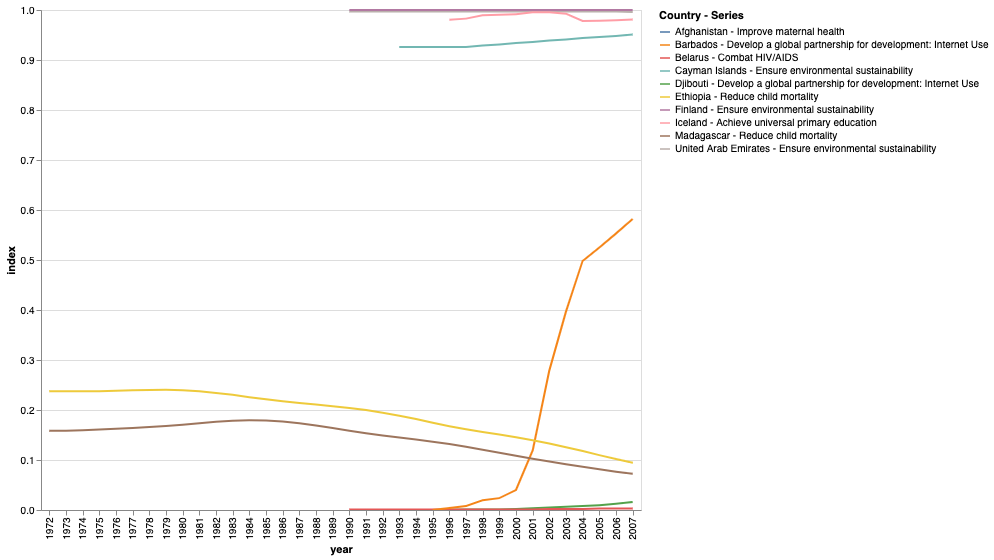

In [184]:
visualiza_10_random_seris(train)

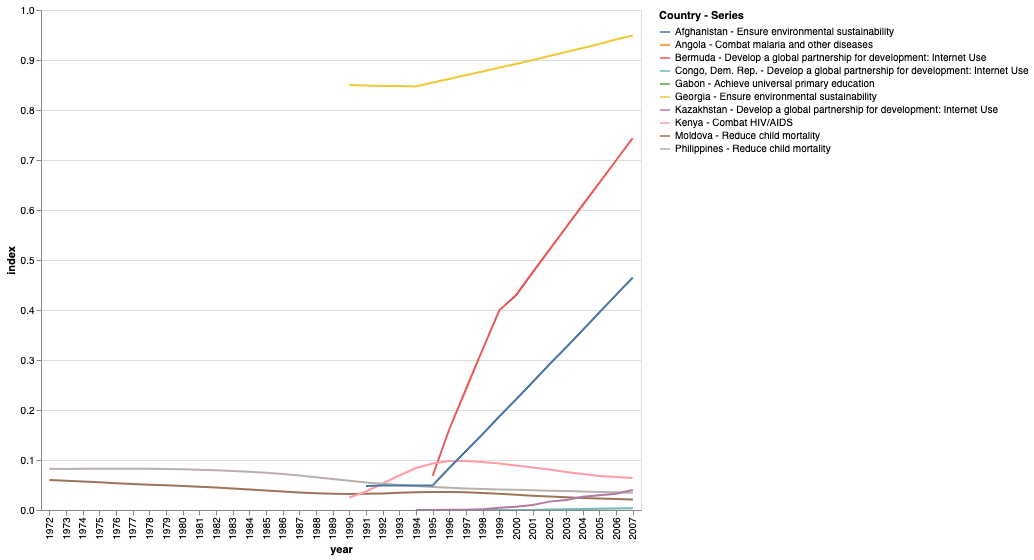

In [185]:
visualiza_10_random_seris(train)

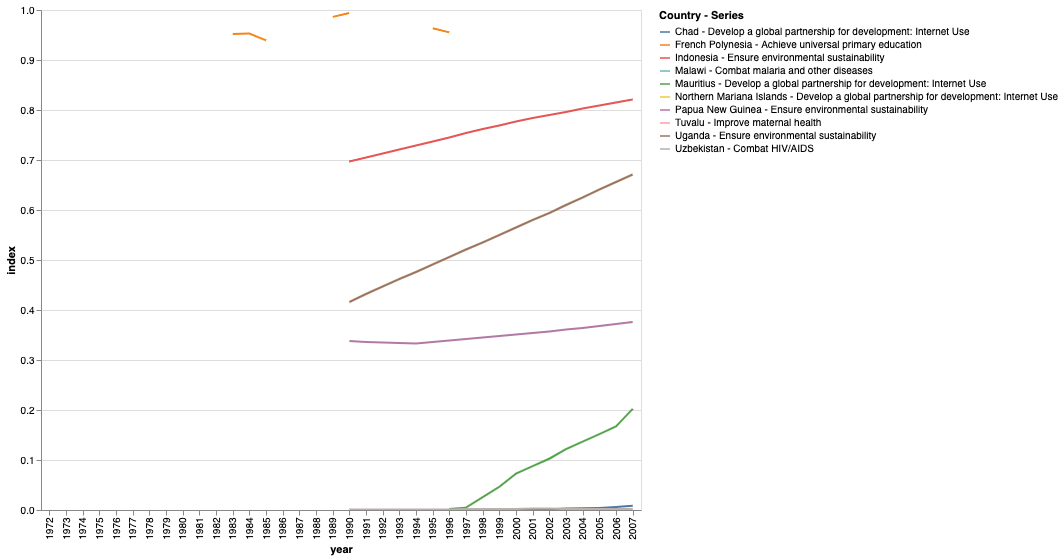

In [186]:
visualiza_10_random_seris(train)

Quite a few observations can be derived from these visualizations. First of all, a lot of data are missing even with the series that we need to predict for. For instance, it is practically impossible to predict anything for the universal primary education index at French Polynesia because most data are missing. Second, the trends are very different among countries for different indexes, although they seem to be stable over time. Even if we do a linear regression extending the slope, I think it won't be extremely far off from the truth. I sure hope these visualizations are at least somewhat representative of the whole picture.

Let's look at some correlations now. We mainly care about correlations between different series. For that, we want to pick a few countries with the least missing data to visualize correlations.

In [334]:
def top_10_countries_most_data(df):
  melted_df = df.melt(
    id_vars=['Country Name', 'Series Name'], 
    value_vars=included_years, 
    var_name='year', 
    value_name='index'
  )
  
  return melted_df.groupby(['Country Name']).count()['index'].sort_values(ascending=False).head(10)

In [466]:
top_10_countries_most_data(train)

Country Name
Mexico           28105
Philippines      27936
Morocco          27879
Peru             27851
Indonesia        27532
Colombia         27527
Costa Rica       27364
Venezuela, RB    27360
Tunisia          27319
Ecuador          27306
Name: index, dtype: int64

In [535]:
mexico = train[train["Country Name"] == 'Mexico']

In [536]:
def visualize_corr(df, positive=True):
  # Concat another df with delayed
  seris_df = df.melt(
    id_vars=['Country Name', 'Series Name'], 
    value_vars=included_years, 
    var_name='year', 
    value_name='index'
  ).pivot(index='year', columns='Series Name', values='index')
  
  delayed_series_df = seris_df.copy()
  delayed_series_df.columns = 'D - ' + delayed_series_df.columns 
  delayed_series_df = delayed_series_df[:-1]
  
  series_df = seris_df[1:]
  delayed_series_df.index = series_df.index

  corr_series_df = pd.concat([series_df, delayed_series_df], axis=1, sort=False)
  corr = corr_series_df.corr(min_periods=4)
  corr = corr[corr.columns & submission_series].dropna(thresh=1)
  
  corr['Correlation Series'] = corr.index
  
  corr = corr.melt(
    value_vars=list(corr.columns & submission_series),
    id_vars=['Correlation Series'],
    var_name='Submission Series',
    value_name='Correlation'
  ).dropna()
  
  return corr.query(
    "0.998 > Correlation > -0.998 and (Correlation >= 0.7 or Correlation <= -0.7)"
  ).sort_values(['Submission Series','Correlation'], ascending=not positive).groupby('Submission Series').head(5)

In [537]:
visualize_corr(mexico)

,Correlation Series,Submission Series,Correlation
11559,D - Number of under-five deaths,Reduce child mortality,0.997923
10197,Forest area (% of land area),Reduce child mortality,0.997902
10198,Forest area (sq. km),Reduce child mortality,0.997902
10330,"Incidence of tuberculosis (per 100,000 people)",Reduce child mortality,0.997847
10569,Number of under-five deaths,Reduce child mortality,0.997671
6862,"Survival to age 65, female (% of cohort)",Ensure environmental sustainability,0.997967
7935,D - Women's share of population ages 15+ livin...,Ensure environmental sustainability,0.997890
6442,"Life expectancy at birth, total (years)",Ensure environmental sustainability,0.997609
7435,"D - Life expectancy at birth, total (years)",Ensure environmental sustainability,0.997517
6827,Scientific and technical journal articles,Ensure environmental sustainability,0.996987


In [538]:
visualize_corr(mexico, positive=False)

,Correlation Series,Submission Series,Correlation
116,"Children out of school, primary",Achieve universal primary education,-0.987171
957,Trained teachers in primary education (% of to...,Achieve universal primary education,-0.981789
1438,"D - Internally displaced persons (number, low ...",Achieve universal primary education,-0.975649
886,Secure Internet servers (per 1 million people),Achieve universal primary education,-0.959546
885,Secure Internet servers,Achieve universal primary education,-0.957250
2060,Births attended by skilled health staff (% of ...,Combat HIV/AIDS,-0.984640
3054,D - Births attended by skilled health staff (%...,Combat HIV/AIDS,-0.983162
2738,"Persistence to last grade of primary, male (% ...",Combat HIV/AIDS,-0.968249
2735,"Persistence to grade 5, male (% of cohort)",Combat HIV/AIDS,-0.962189
2737,"Persistence to last grade of primary, female (...",Combat HIV/AIDS,-0.951091


In [539]:
philippines = train[train["Country Name"] == 'Philippines']

In [540]:
visualize_corr(philippines)

,Correlation Series,Submission Series,Correlation
11551,"D - Mortality rate, infant (per 1,000 live bir...",Reduce child mortality,0.997721
11643,D - Organic water pollutant (BOD) emissions (k...,Reduce child mortality,0.984923
10645,Organic water pollutant (BOD) emissions (kg pe...,Reduce child mortality,0.983402
10048,Arable land (hectares per person),Reduce child mortality,0.983030
11075,"D - Birth rate, crude (per 1,000 people)",Reduce child mortality,0.982264
6138,Consumer price index (2010 = 100),Ensure environmental sustainability,0.997797
7139,D - Consumer price index (2010 = 100),Ensure environmental sustainability,0.997752
7359,D - Gross national expenditure deflator (base ...,Ensure environmental sustainability,0.997017
6358,Gross national expenditure deflator (base year...,Ensure environmental sustainability,0.996916
7493,D - Livestock production index (2004-2006 = 100),Ensure environmental sustainability,0.996856


In [541]:
visualize_corr(philippines, positive=False)

,Correlation Series,Submission Series,Correlation
58,"Automated teller machines (ATMs) (per 100,000 ...",Achieve universal primary education,-0.977397
909,Subsidies and other transfers (current LCU),Achieve universal primary education,-0.974012
1905,D - Subsidies and other transfers (current LCU),Achieve universal primary education,-0.970124
234,Expense (current LCU),Achieve universal primary education,-0.968317
804,Private credit bureau coverage (% of adults),Achieve universal primary education,-0.965773
4129,"Commercial bank branches (per 100,000 adults)",Develop a global partnership for development: ...,-0.987654
5867,"D - School enrollment, secondary, private (% o...",Develop a global partnership for development: ...,-0.986604
4993,"Water pollution, food industry (% of total BOD...",Develop a global partnership for development: ...,-0.976801
5542,D - Military expenditure (% of central governm...,Develop a global partnership for development: ...,-0.976022
4648,Organic water pollutant (BOD) emissions (kg pe...,Develop a global partnership for development: ...,-0.974430


There are strong positive and negative correlations with different series. The strength of the correlations are different across different countries. A lot of the strong correlations are lagged. In terms of lagged correlations, there is definitely potential for fruitful feature engineering.